# Rain in Australia

Predict next-day rain by training classification models on the target variable RainTomorrow. [Fom kaggle](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package?select=weatherAUS.csv)

<p style="color: #FFFFFF;background: #7E000080; text-align: center; padding:5px 5px; font-weight: 400">⚠️<b>SPOILER</b>⚠️<br> No pude tener un buen rendimiento😔 El dataset tiene varias variables categoricas con alta cardinalidad (ví repos en kaggle donde hacen el One Hot, queda con muchas columnas y da el mismo rendimiento) por lo que no supe que hacer con tanta cardinalidad, y borré las columnas, vi que con redes neuronales se puede solucionar el problema, pero no sé, cuando sepa de redes lo volveré a intentar, por ahora hice lo que pude</p> 

Ejemplos de notebooks que igual da el mismo rendimiento maluco
- [Jovian, lo encontré en freecodecamp](https://jovian.ai/aakashns/python-sklearn-logistic-regression)
- [Lo encontré en kaggle, me ayudó bastante pero el mismo rendimiento](https://www.kaggle.com/code/mohamedsameh0410/eda-rain-prediction-random-forest-xg-boost#Imports)
- [En la matrix de confusion se puede ver que el rendimiento también está cagado](https://www.kaggle.com/code/prashant111/extensive-analysis-eda-fe-modelling)

# Importamos las librerias
Perdonen el desorden, las puse según el orden de necesidad

In [150]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from custom_transformers import YesNoTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.base import clone
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline

# Cargando el dataset

In [151]:
data = pd.read_csv('weatherAUS.csv')

In [152]:
data.sample(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
14044,2014-08-29,Moree,3.7,20.9,0.0,NaN,NaN,SSW,52.0,SE,...,46.0,27.0,1026.0,1021.5,NaN,NaN,14.2,19.4,No,No
80231,2015-05-21,Watsonia,9.3,12.4,9.2,2.2,0.0,SW,35.0,WSW,...,100.0,88.0,1023.7,1023.2,8.0,7.0,9.9,12.1,Yes,No
145255,2016-12-03,Uluru,23.6,31.9,0.4,NaN,NaN,N,48.0,NE,...,43.0,39.0,1009.8,1009.0,8.0,8.0,29.2,29.3,No,No
48792,2016-11-07,Canberra,6.5,25.3,0.0,NaN,NaN,N,59.0,NW,...,50.0,38.0,1010.6,1006.5,NaN,NaN,17.1,24.0,No,No
98696,2015-04-01,Adelaide,17.2,30.4,0.0,5.2,NaN,NNW,44.0,NE,...,29.0,30.0,1016.1,1014.1,NaN,NaN,23.1,28.2,No,No


In [153]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

# EDA

## ydata profiling
Acá el ``ydata_profiling`` me da problemas de compatibilidad con seaborn y otras librerias por lo que hago algo muy bobo, primero instalo esta libreria y hago el reporte y luego borro el `env` y luego instalo si el resto

In [154]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(data, title="Pandas Profiling Report")
# profile.to_file("weather_report.html")

## Missing values

In [155]:
data.isnull().sum().sort_values(ascending=False)/len(data)

Sunshine         0.480098
Evaporation      0.431665
Cloud3pm         0.408071
Cloud9am         0.384216
Pressure9am      0.103568
Pressure3pm      0.103314
WindDir9am       0.072639
WindGustDir      0.070989
WindGustSpeed    0.070555
Humidity3pm      0.030984
WindDir3pm       0.029066
Temp3pm          0.024811
RainTomorrow     0.022460
Rainfall         0.022419
RainToday        0.022419
WindSpeed3pm     0.021050
Humidity9am      0.018246
Temp9am          0.012148
WindSpeed9am     0.012148
MinTemp          0.010209
MaxTemp          0.008669
Location         0.000000
Date             0.000000
dtype: float64

En este caso, siempre se me complica lidiar con valores faltantes, voy a hacerlo sencillo y no matarme la cabeza
1. Eliminar las primeras cuatro columnas, tienen casi que la mitad en valores nulos

In [156]:
data = data.drop(columns=['Sunshine','Evaporation','Cloud3pm','Cloud9am'])

2. Veré por separado, de tipos numericos y no numericos

In [157]:
data_cat = data.select_dtypes(exclude='number').columns
data[data_cat].isnull().sum().sort_values(ascending=False)/len(data[data_cat])

WindDir9am      0.072639
WindGustDir     0.070989
WindDir3pm      0.029066
RainTomorrow    0.022460
RainToday       0.022419
Date            0.000000
Location        0.000000
dtype: float64

3. Como las categoricas tienen un nivel de datos nulos muy pequeño eliminaré las filas

In [158]:
data = data.dropna(subset=data_cat)

4. Para las numericas y evitar perder más datos usaré el simpleImputer

In [159]:
data_num = data.select_dtypes(include='number').columns
data[data_num].isnull().sum().sort_values(ascending=False)/len(data[data_num])

Pressure9am      0.073721
Pressure3pm      0.073309
Humidity3pm      0.012303
Humidity9am      0.008180
Temp3pm          0.006426
Temp9am          0.002773
MinTemp          0.000728
MaxTemp          0.000364
Rainfall         0.000000
WindGustSpeed    0.000000
WindSpeed9am     0.000000
WindSpeed3pm     0.000000
dtype: float64

In [160]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(data[data_num])
data_imputed = imputer.transform(data[data_num])

data_imputed = pd.DataFrame(data_imputed, columns=data_num, index=data[data_num].index)

5. Finalizo uniendo los categoricos con numericos

In [161]:
data = pd.concat([data_imputed, data[data_cat]], axis=1)

## Outliers

In [162]:
data.describe()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm
count,123710.000000,123710.000000,123710.000000,123710.000000,123710.000000,123710.000000,123710.000000,123710.000000,123710.000000,123710.000000,123710.000000,123710.000000
mean,12.414077,23.474900,2.375661,40.685280,15.011689,19.174578,67.654281,50.848406,1017.398144,1015.011596,17.269634,21.897078
std,6.366789,7.205896,8.528039,13.388636,8.307285,8.571039,18.975181,20.839429,6.765371,6.703515,6.477866,7.005844
min,-8.500000,-4.800000,0.000000,7.000000,2.000000,2.000000,0.000000,0.000000,980.500000,977.100000,-7.200000,-5.400000
25%,7.800000,18.100000,0.000000,31.000000,9.000000,13.000000,56.000000,36.000000,1013.200000,1010.700000,12.500000,16.800000
50%,12.200000,23.000000,0.000000,39.000000,13.000000,19.000000,68.000000,51.000000,1017.398144,1015.011596,17.000000,21.500000
75%,17.000000,28.600000,0.800000,48.000000,20.000000,24.000000,81.000000,65.000000,1021.700000,1019.300000,21.900000,26.700000
max,33.900000,48.100000,367.600000,135.000000,87.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,40.200000,46.700000


No vemos mucho outliers así que seguimos

## Fetarue engineering
Solo voy a cambiar el formato

In [163]:
data['Date'] = pd.to_datetime(data['Date'],format='%Y-%m-%d')

## Feature encoding

In [164]:
data[data_cat].info()

<class 'pandas.core.frame.DataFrame'>
Index: 123710 entries, 0 to 145458
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date          123710 non-null  datetime64[ns]
 1   Location      123710 non-null  object        
 2   WindGustDir   123710 non-null  object        
 3   WindDir9am    123710 non-null  object        
 4   WindDir3pm    123710 non-null  object        
 5   RainToday     123710 non-null  object        
 6   RainTomorrow  123710 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 7.6+ MB


Vemos cual variable se le puede hacer encoding, por ahora a las dos ultimas, debido a que no tienen muchos valores y se puede hacer de manera binaria

In [165]:
data['RainToday'].value_counts()

RainToday
No     95954
Yes    27756
Name: count, dtype: int64

El ``YesNoTransformer`` lo tengo en una clase aparte para hacer el pipeline

In [166]:
data['RainToday'] = YesNoTransformer().fit_transform(data[['RainToday']])
data['RainTomorrow'] = YesNoTransformer().fit_transform(data[['RainTomorrow']])

Voy a ver un poco mejor como se distribuye la fecha en meses, año y dias.

In [167]:
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day

No sé si estoy ciego, depronto, pero no veo que influya mucho el año, depronto mes, pero muy poco y dia mucho menos, así que descartaré esto

<Axes: xlabel='month', ylabel='Count'>

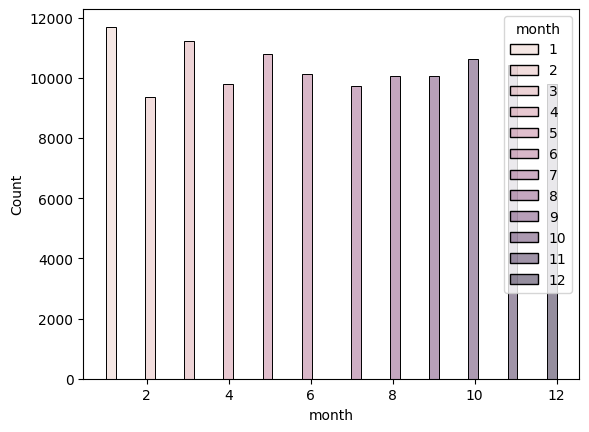

In [168]:
sns.histplot(data=data, x='month', hue='month')

In [169]:
data = data.drop(columns=['Date','month','year','day'])

<p style="color: #FFFFFF;background: #7E000080; text-align: center; padding:5px 5px; font-weight: 400">Voy a eliminar las columnas con alta cardinalidad a las que no le puedo hacer encoding, viendo en internet, con redes neuronales se puede hacer un encoding llamado EMBEDDING, pero por ahora no sé mucho de redes neuronales, y como tamapoco encuentro mucha información en internet voy a optar por eliminarlas mientras aprendo un método mejor</p>

In [170]:
data = data.drop(columns=['Location','WindGustDir','WindDir9am','WindDir3pm'])

## Correlation

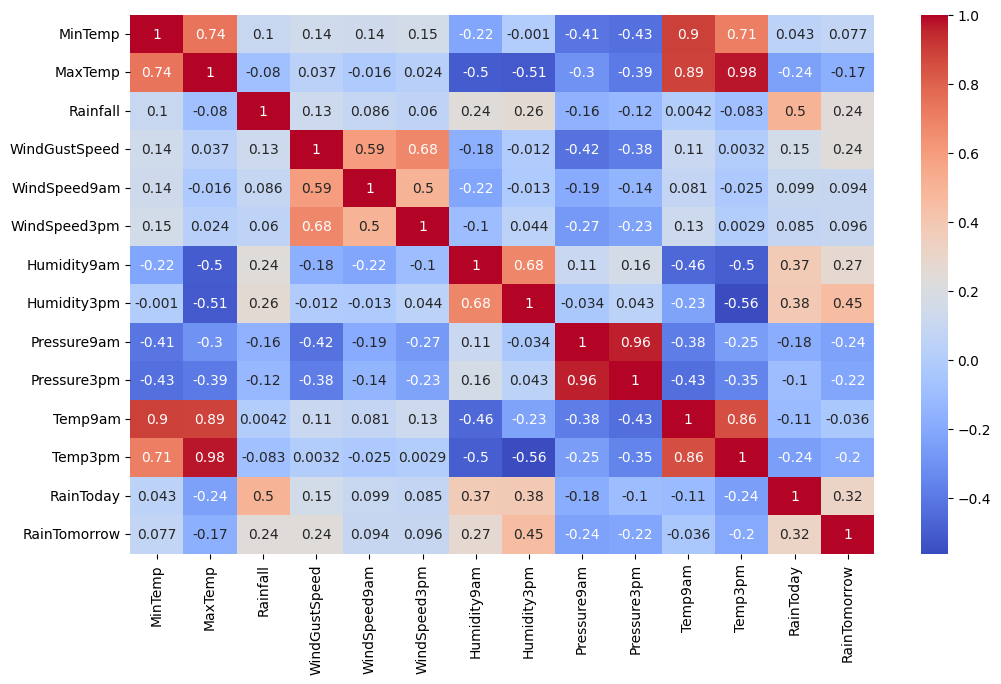

In [171]:
num_cols = data.select_dtypes(include=['number']).columns
plt.figure(figsize=(12,7))
sns.heatmap(data[num_cols].corr() ,annot= True , cmap= 'coolwarm');

En este caso voy a eliminar las variables que se relacionan mucho, una técnica que aprendí es, ver las variables con correlacion alta y luego compararlas con el target, y eliminar la más cercana a 0

In [172]:
print(data['MinTemp'].corr(data['Temp9am']))
print(data['RainTomorrow'].corr(data['Temp9am']))
print(data['RainTomorrow'].corr(data['MinTemp']))

0.8960089796014962
-0.036282633194482744
0.07662758292677646


In [173]:
data = data.drop(columns=['Temp9am'])

In [174]:
print(data['MaxTemp'].corr(data['Temp3pm']))
print(data['RainTomorrow'].corr(data['Temp3pm']))
print(data['RainTomorrow'].corr(data['MaxTemp']))

0.975208157821435
-0.20043386500696872
-0.16845462870959488


In [175]:
data = data.drop(columns=['MaxTemp'])

In [176]:
print(data['Pressure3pm'].corr(data['Pressure9am']))
print(data['RainTomorrow'].corr(data['Pressure3pm']))
print(data['RainTomorrow'].corr(data['Pressure9am']))

0.9595400675271194
-0.2155767307969935
-0.2353424322957453


In [177]:
data = data.drop(columns=['Pressure3pm'])

## Train test split
Creo tener sufiencientes datos para hacer 3 grupos

In [178]:
X = data.drop(['RainTomorrow'], axis=1).copy()
y = data['RainTomorrow'].copy()

In [179]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.4, random_state=42,stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42,stratify=y_rest)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_val.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento: (74226, 10)
Tamaño del conjunto de validación: (24742, 10)
Tamaño del conjunto de prueba: (24742, 10)


## Feature Scaling

In [180]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

# Model

Usaré optuna para tener los hiperparámetros del modelo, luego de usarlo lo comentaré porque consume mucho computo

In [181]:
# import optuna
# from sklearn.ensemble import RandomForestClassifier
# study = optuna.create_study(direction="maximize")

# def objective(trial):
#     criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
#     max_depth = trial.suggest_int("max_depth", 2, 10)
#     n_stimators = trial.suggest_int("n_estimators", 10, 100)
    
#     model = RandomForestClassifier(criterion=criterion, max_depth=max_depth, n_estimators=n_stimators,random_state=42)
    
#     model.fit(X_train_scaled, y_train)    
#     return model.score(X_val_scaled, y_val)

# study.optimize(objective, n_trials=100)
# print(f'Best parameters: {study.best_params}')
# print(f'Best score: {study.best_value}')

In [182]:
model = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=91,random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10, n_estimators=91, random_state=42)

> <b>Dato curioso:</b> Usé ``RFE`` para seleccionar caracteristicas y dio oigual a ``feature_importance``, por eso quité el ``RFE``

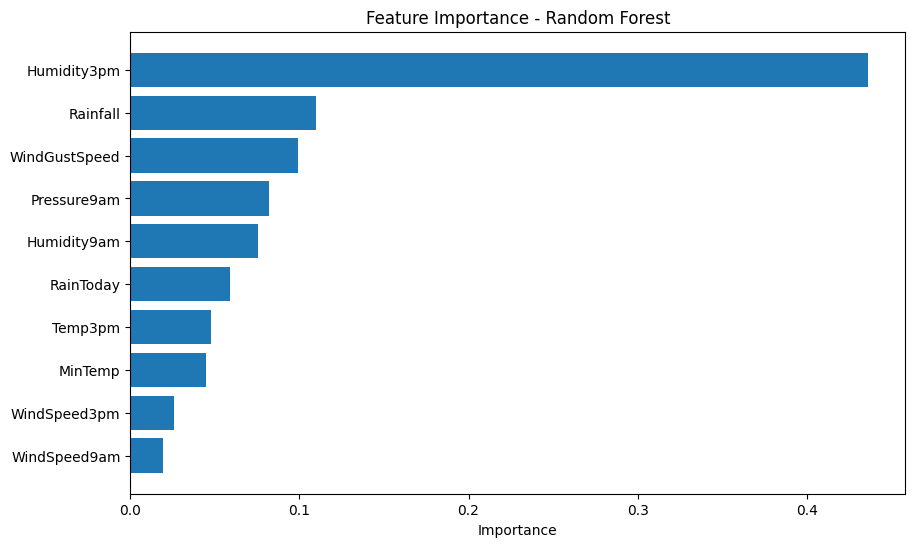

In [183]:
feature_importance = model.feature_importances_
sorted_idx = feature_importance.argsort()

sorted_idx

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), X_train.columns[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest')
plt.show()

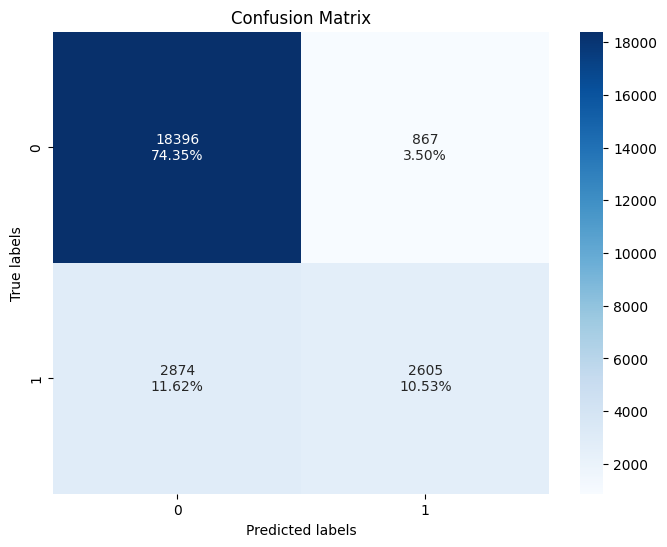

In [184]:
cm = confusion_matrix(y_val, model.predict(X_val_scaled))
names = [value for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{name}\n{percentage}' for name, percentage in zip(names,percentages)]
labels = np.asarray(labels).reshape(2, 2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, cmap='Blues', fmt='')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [185]:
pred = model.predict(X_val_scaled)
print(f'Recall: {recall_score(y_val, pred)}')
print(f'Accuracy: {accuracy_score(y_val, pred)}')

Recall: 0.4754517247672933
Accuracy: 0.8487996119957966


# Pipeline

In [186]:
simple_imputer = ColumnTransformer([
    ('simple_imputer',
    SimpleImputer(strategy='mean'),
    ['MinTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
        'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am','Temp3pm'])
])

yes_no = ColumnTransformer([
    ('yes_no',
    YesNoTransformer(),
    ['RainToday'])
])

scaler = ColumnTransformer([
    ('scaler',
    MinMaxScaler(),
    ['MinTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
        'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Temp3pm', 'RainToday'])
])

In [187]:
feature_ingineering_pipe = Pipeline([
        (
            "features",
            FeatureUnion(
                [
                    ("simple_imputer", simple_imputer),
                    ("yes_no", yes_no),
                    ("scaler", scaler),
                ]
            ),
        )
])

In [188]:
model_pipe = Pipeline([
        ('Feature_engineering',clone(feature_ingineering_pipe)),
        ('model',RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=91,random_state=42))
])

## Model Testing
Voy a probar ahora con los test que nunca toqué, para eso uno los `train` con los `val`

In [189]:
df_x = pd.concat([X_train,X_val])
df_y = pd.concat([y_train, y_val])

In [190]:
model_pipe.fit(df_x, df_y)

Pipeline(steps=[('Feature_engineering',
                 Pipeline(steps=[('features',
                                  FeatureUnion(transformer_list=[('simple_imputer',
                                                                  ColumnTransformer(transformers=[('simple_imputer',
                                                                                                   SimpleImputer(),
                                                                                                   ['MinTemp',
                                                                                                    'Rainfall',
                                                                                                    'WindGustSpeed',
                                                                                                    'WindSpeed9am',
                                                                                                    'WindSpeed3pm',
                                                                                                    'Humidity9am',
                                                                                                    'Humidity3pm',
                                                                                                    'Pressure9am',
                                                                                                    'Temp3pm'])])),
                                                                 ('yes_no',
                                                                  ColumnTransformer(transformers=[('yes_no',
                                                                                                   YesNoTransformer(),
                                                                                                   ['RainToday'])])),
                                                                 ('scaler',
                                                                  ColumnTransformer(transformers=[('scaler',
                                                                                                   MinMaxScaler(),
                                                                                                   ['MinTemp',
                                                                                                    'Rainfall',
                                                                                                    'WindGustSpeed',
                                                                                                    'WindSpeed9am',
                                                                                                    'WindSpeed3pm',
                                                                                                    'Humidity9am',
                                                                                                    'Humidity3pm',
                                                                                                    'Pressure9am',
                                                                                                    'Temp3pm',
                                                                                                    'RainToday'])]))]))])),
                ('model',
                 RandomForestClassifier(max_depth=10, n_estimators=91,
                                        random_state=42))])

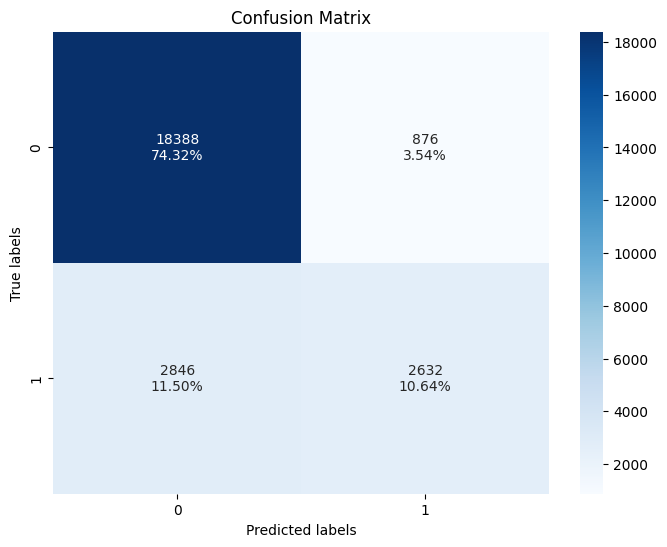

In [191]:
predit_pipe = model_pipe.predict(X_test)

cm = confusion_matrix(y_test, predit_pipe)
names = [value for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{name}\n{percentage}' for name, percentage in zip(names,percentages)]
labels = np.asarray(labels).reshape(2, 2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, cmap='Blues', fmt='')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [192]:
print(f'Recall: {recall_score(y_test, predit_pipe)}')
print(f'Accuracy: {accuracy_score(y_val, predit_pipe)}')

Recall: 0.4804673238408178
Accuracy: 0.69828631476841


# Conclusión

No pude lograr un mejor rendimiento, quizá por mi experiencia, cuando aprenda mejores maneras o redes neuroanales intento denuevo, además que viendolo mejor no hay muchos datos cuando llueve, por lo mismo creo que el modelo no predice bien cuando llueve, busqué información en otros notebooks de personas random y les dio un rendimiento similar, así que será esperar e intentarlo más adelante.